In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

In [ ]:
class DomIdLoader:
    def __init__(self):
        self.offset_ = 1
        self.limit_ = 5000
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36',
        }


    def get_ids(self):
        paramz = {
            'offset': self.offset_,
            'limit': self.limit_,
            'sortField': 'devId.devShortCleanNm',
            'sortType': 'asc',
            'objStatus': '0',
        }
        res = requests.get(self.url, headers=self.headers, params=paramz)
        objects_data = res.json()
        objids = [x.get('objId') for x in objects_data.get('data').get('list')]
        return objids

    def show_ids(self):
        print(self.get_ids())

In [ ]:
class ObjectInfoExtractor:
    def __init__(self):
        self.objids = DomIdLoader().get_ids()
        self.headers = DomIdLoader().headers
        self.objects_array = []
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/'

    def load_data(self):
        for i in range(len(self.objids)):
            url_object = self.url + f'{self.objids[i]}'
            try:
                objitem = requests.get(url_object, headers=self.headers)
                objitemjs = objitem.json()
                data_item = objitemjs.get('data')
                res_img = [x.get('objRenderPhotoUrl') for x in data_item.get('photoRenderDTO')]

                data = self.df_converter(data_item, res_img, i)
                self.objects_array.append(data)
            except:
                continue
        return self.objects_array

    def df_converter(self, data_item, res_img, index):
        data = pd.DataFrame({
            'region': data_item.get('region') if data_item.get('region') else None,
            'year': datetime.datetime.strptime(data_item.get('objReady100PercDt'), "%Y-%m-%d").year if data_item.get(
                'objReady100PercDt') else None,
            'date': data_item.get('objReady100PercDt') if data_item.get('objReady100PercDt') else None,
            'objPriceAvg': data_item.get('objPriceAvg') if data_item.get('objPriceAvg') else None,
            'objFloorCnt': data_item.get('objFloorCnt') if data_item.get('objFloorCnt') else None,
            'objFlatCnt': data_item.get('objFlatCnt') if data_item.get('objFlatCnt') else None,
            'objSquareLiving': data_item.get('objSquareLiving') if data_item.get('objSquareLiving') else None,
            'objElemParkingCnt': data_item.get('objElemParkingCnt') if data_item.get('objElemParkingCnt') else None,
            'img': res_img[0]
        }, index=[index])
        return data

In [ ]:
class Saver:
    def __init__(self, data, name):
        self.objects_res = pd.concat(data)
        self.name = name

    def save_csv(self):
        self.objects_res.to_csv(self.name + ".csv")

    def save_json(self):
        self.objects_res.to_json(self.name + ".json")

In [ ]:
class Visualizer:
    def __init__(self):
        self.data = pd.read_json('/content/testOOP.json')

    def make_boxplot(self):
        rcParams['figure.figsize'] = 16, 7
        self.avg_list = []
        list_col = ['region',
                    'year',
                    'date',
                    'objPriceAvg',
                    'objFloorCnt',
                    'objFlatCnt',
                    'objSquareLiving',
                    'objElemParkingCnt',
                    'img']
        for i in list_col:
            if i != "img" and i != "date":
                filter = self.data[i].notna()
                if i == 'region':
                    avg = self.data.loc[filter].groupby('region')[i].count()
                    avg.sort_values(ascending=True).plot(kind='bar')
                    plt.title('graph_' + i)
                    plt.show()
                    self.avg_list.append(avg)
                elif i == 'year':
                    avg = self.data.loc[filter].groupby('year')['region'].count()
                    avg.sort_values(ascending=True).plot(kind='bar')
                    plt.title('graph_' + i)
                    plt.show()
                else:
                    avg = self.data.loc[filter].groupby('region')[i].mean()
                    avg.sort_values(ascending=True).plot(kind='bar')
                    plt.title('graph_' + i)
                    plt.show()
                    self.avg_list.append(avg)

        avg_price_for_square = self.data.loc[self.data['objSquareLiving'].notna()].groupby('region')[
                                   'objSquareLiving'].mean() / \
                               self.data.loc[self.data['objPriceAvg'].notna()].groupby('region')['objPriceAvg'].mean()
        avg_price_for_square.sort_values(ascending=True).plot(kind='bar')
        plt.title("Цена за квадратный метр")
        plt.show()
        self.avg_list.append(avg_price_for_square)

    def make_heatmap(self, avg_list):
        for item in avg_list:
            item.plot(logy=True)

        plt.title('График зависимостей')
        plt.legend(["Объем вводимого жилья по регионам", "Средняя цена", "Средняя этажность", "Среднее количество квартир",
                    "Средняя жилая площадь", "Среднее количество парковочных мест", "Средняя цена за кв.м"])
        plt.show()


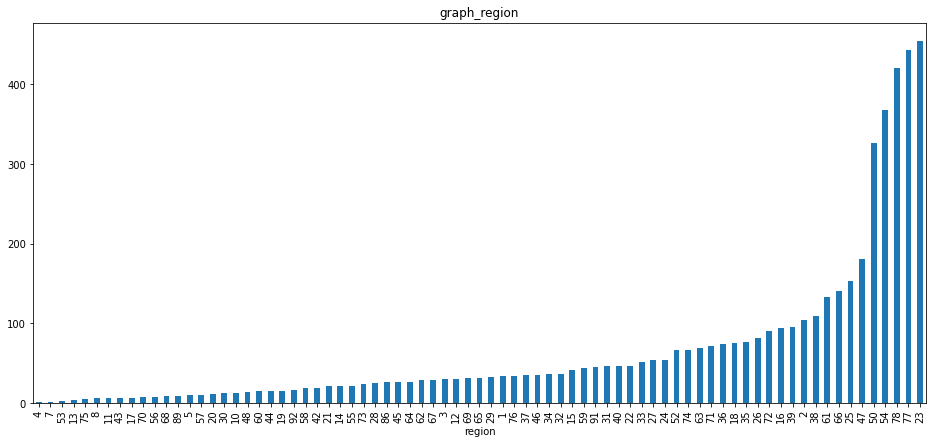

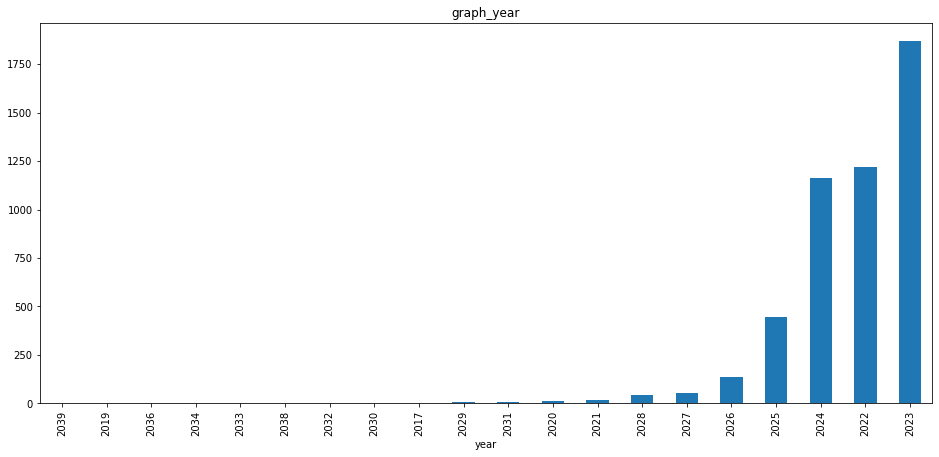

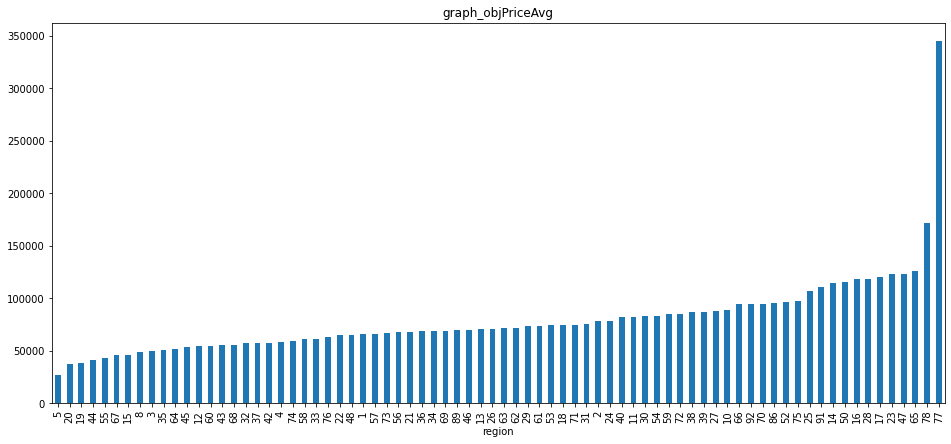

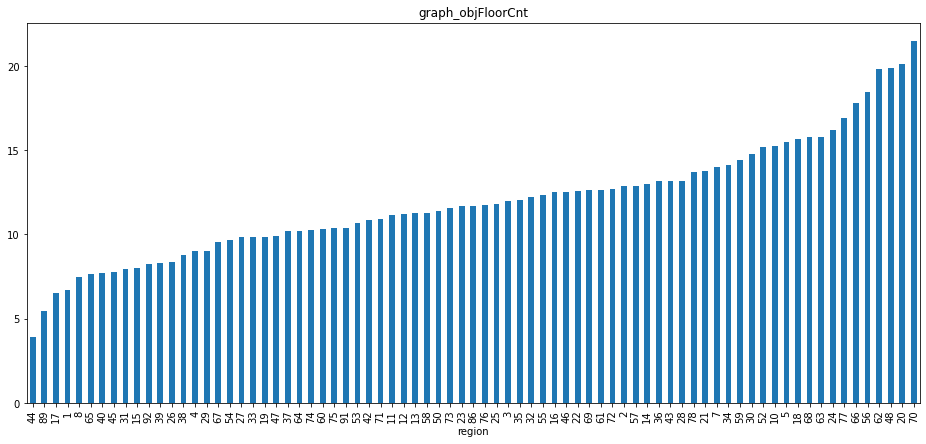

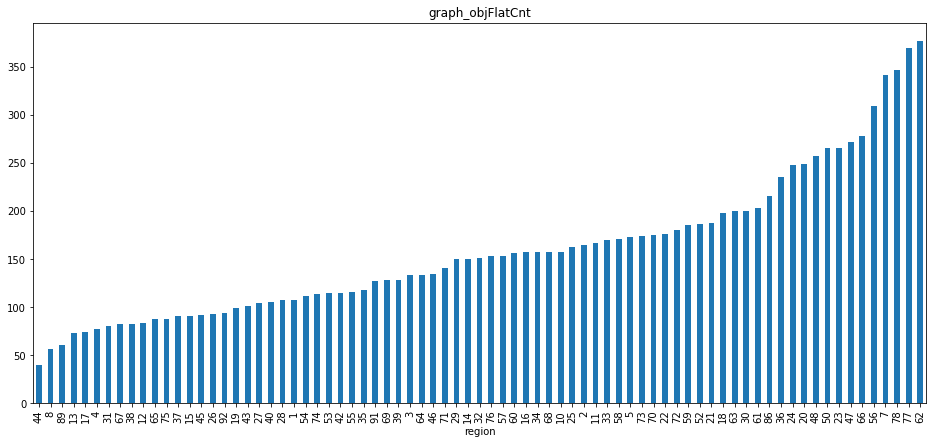

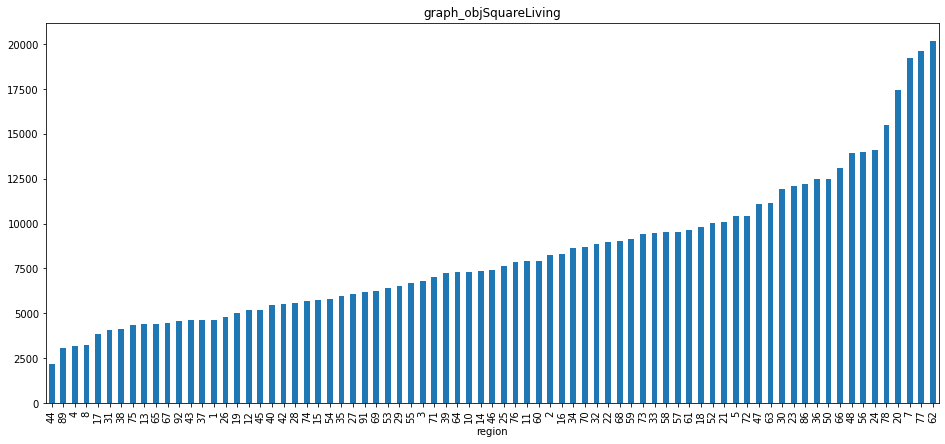

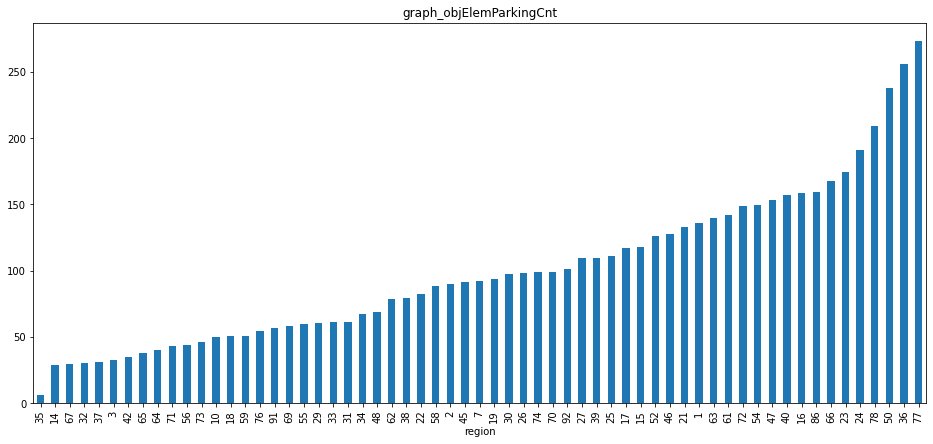

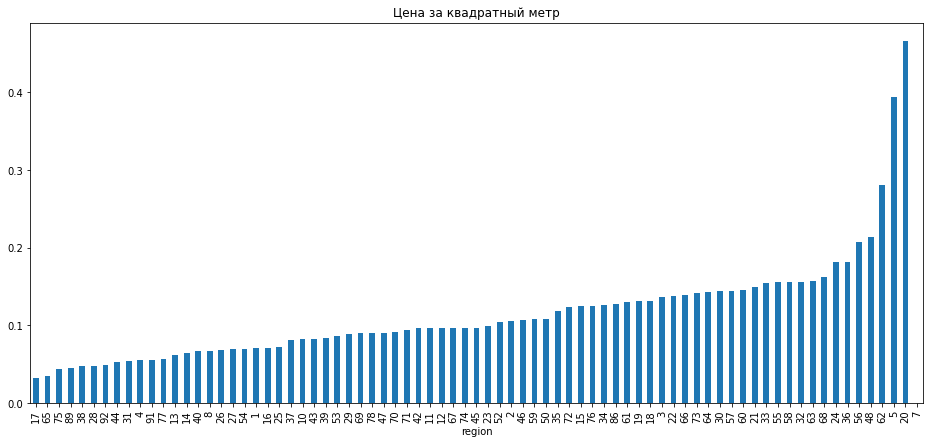

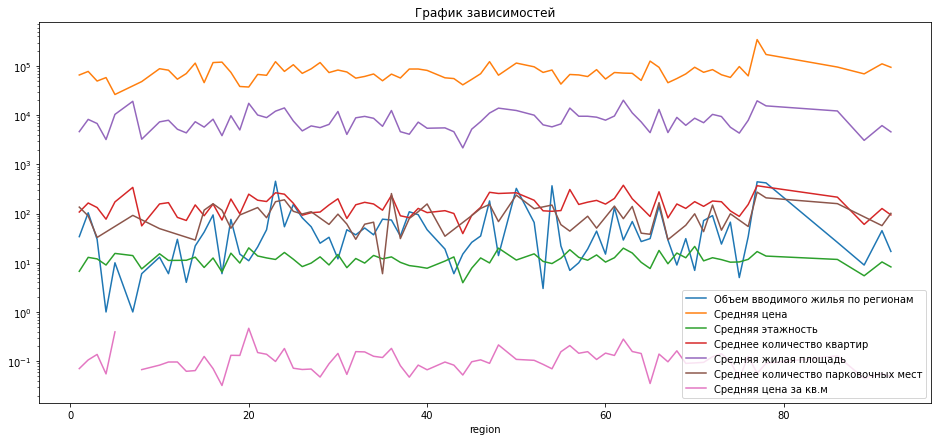

In [ ]:
data = ObjectInfoExtractor().load_data()
res = Saver(data, "testOOP")
res.save_json()

shape = Visualizer()
shape.make_boxplot()
shape.make_heatmap(shape.avg_list)
